In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import openml
import pandas as pd
import json
import pickle
import sys
sys.path.append("..")

In [2]:
names = {
    "HAverage": "HAverage",
    "KMedoids": "K-Medoids",
}

baseline_pairs = {
    "HAverage": "manhattan_hamming",
    "KMedoids": "euclidean_hamming"
}

train_res_files = {name: f"data/{name}/training_results.pickle" for name in names}
times_file = {name: f"data/{name}/benchmark_times.json" for name in names}
meta_feat_times = "data/meta_features_times.json"

In [3]:
openml_df = openml.datasets.list_datasets(output_format="dataframe")
df = openml_df[openml_df.NumberOfNumericFeatures >= 1]

df = df[df.NumberOfInstances >= 50]
df = df[df.NumberOfSymbolicFeatures >= 2]
df = df[df.NumberOfMissingValues == 0]
df = df[df.NumberOfClasses > 0]
df = df[df.NumberOfClasses < 100]
df = df[df.version == 1]
n_matching_datasets = len(df)
dict_ = {"NumberOfFeatures":"Features", "NumberOfInstances": "Instances", "NumberOfNumericFeatures":"Num. Features", "NumberOfSymbolicFeatures": "Cat. Features", "NumberOfClasses": "Classes"}
df= df.rename(columns=dict_)

selected_datasets = pd.read_csv("data/selected_datasets.csv", sep=" ", index_col="id")
df = df.loc[selected_datasets.index,]

print("Description of selected data sets:")
df[dict_.values()].describe().astype(int)

Description of selected data sets:


,Features,Instances,Num. Features,Cat. Features,Classes
count,94,94,94,94,94
mean,49,170609,36,12,4
std,171,369206,167,19,7
min,3,50,1,2,2
25%,9,235,3,3,2
50%,17,1286,7,6,2
75%,33,9851,17,15,5
max,1637,1455525,1599,137,48


In [4]:
with open(meta_feat_times, "r") as f:
    durations = json.load(f)
    total_time = sum(durations.values())
    print("Meta-features extraction:\t", str(timedelta(seconds=total_time)))

for name, filename in times_file.items():
    with open(filename, "r") as f:
        durations = json.load(f)
        total_time = sum(durations.values())
        print(f"Benchmark {names[name]}:\t\t", str(timedelta(seconds=total_time)))

Meta-features extraction:	 12:18:12.771256
Benchmark HAverage:		 30 days, 20:04:38.339997
Benchmark K-Medoids:		 63 days, 6:09:09.212209


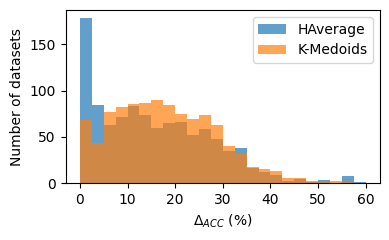

In [5]:
np.random.seed(12333)

variation_range = []
med = []
min_ = []
max_ = []
train_res = {}
for k, train_res_file in train_res_files.items():
    with open(train_res_file, "rb") as f:
        train_res[k] = pickle.load(f)
    variation_range.append([(max(y) - min(y[y>0]))/max(y)*100 for y in train_res[k]["Y"]])
    min_.append([min(y[y>0]) for y in train_res[k]["Y"]])
    max_.append([max(y[y>0]) for y in train_res[k]["Y"]])
    med.append([(max(y) - np.quantile(y[y>0], 0.25))/max(y) for y in train_res[k]["Y"]])

plt.figure(figsize=(4, 2.5))
# plt.scatter(min_[0], max_[0], s=5)
plt.hist(variation_range[0], range=[0, 60], bins=24, alpha=0.7, label="HAverage")
plt.hist(variation_range[1], range=[0, 60], bins=24, alpha=0.7, label="K-Medoids")
plt.xlabel("$\Delta_{ACC}$ (%)")
plt.ylabel("Number of datasets")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
from meta_learners import ndcg

ndcg_ranks = [1, 3, 5, 10, 15, 20]
n_bests = [1, 3, 5, 10]

results = {}
for algo, t in train_res.items():
    Y = t["Y"]
    results[algo] = {}
    results[algo]["proposed"] = {}
    results[algo]["ARB"] = {}
    results[algo]["ARB"]["ndcg"] = {k:[] for k in ndcg_ranks}
    results[algo]["ARB"]["kendall"] = []
    results[algo]["ARB"]["scores"] = {k:[] for k in n_bests}
    results[algo]["LB"] = {}
    results[algo]["LB"]["scores"] = []
    results[algo]["Best"] = {}
    results[algo]["Best"]["scores"] = []
    for split, res in t["train_results"].items():
        train_index, test_index = res["train_index"], res["test_index"]
        Y_train, Y_test = Y[train_index], Y[test_index]
        for model_name, Y_pred in res["predictions"].items():
            if model_name not in results[algo]["proposed"]:
                results[algo]["proposed"][model_name] = {}
                results[algo]["proposed"][model_name]["ndcg"] = {k:[] for k in ndcg_ranks}
                results[algo]["proposed"][model_name]["scores"] = {k:[] for k in n_bests}
            for p in ndcg_ranks:
                results[algo]["proposed"][model_name]["ndcg"][p].append(ndcg(Y_test, Y_pred, p=p))
            for k in n_bests:
                results[algo]["proposed"][model_name]["scores"][k].append(np.array(
            [max(y[y > 0][np.argsort(-Y_pred[i][y > 0])[:k]]) for i, y in enumerate(Y_test)]))

        ar = np.array([np.mean([v for v in Y_train[:, j] if v > 0]) for j in range(Y_train.shape[1])])
        for p in ndcg_ranks:
            results[algo]["ARB"]["ndcg"][p].append(ndcg(Y_test, np.array([ar for _ in Y_test]), p=p))
        for k in n_bests:
            results[algo]["ARB"]["scores"][k].append(np.array(
                [max(y[y > 0][np.argsort(-ar[y > 0])[:k]]) for y in Y_test]))

        sim_pairs_index = dict(zip(t["similarity_pairs"], range(len(t["similarity_pairs"]))))
        results[algo]["LB"]["scores"].append(Y_test[:, sim_pairs_index[baseline_pairs[algo]]])
        results[algo]["Best"]["scores"].append(np.max(Y_test, axis=1))

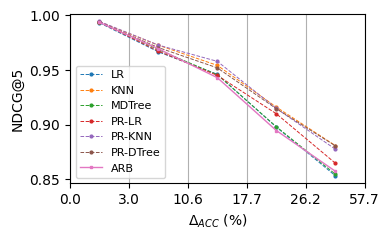

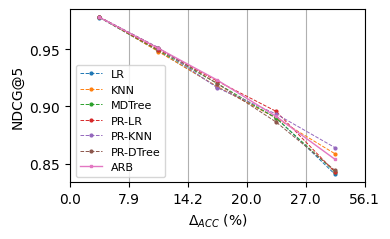

In [7]:
def show_ndcg_delta(results, k=5, savedir=None): 
    baselines = ["ARB"]
    model_names = ["LR", "KNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"]
    for algo, res in results.items():
        plt.figure(figsize=(4, 2.5))
        y = {}
        Y = np.concatenate([train_res[algo]["Y"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
        l = [(max(y[y>0]) - np.quantile(y[y>0], 0.))/max(y[y>0]) for y in Y]
        x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 6)])
        
        x[0] -= 1e-4
        list_indices = [
            np.concatenate([
                [xr < (max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) - np.quantile(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0], 0.))/max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) <= x[r+1] for i in v["test_index"]] #
                for v in train_res[algo]["train_results"].values()
            ]) for r, xr in enumerate(x[:-1])
        ]

        for model_name in model_names:
            y[model_name] = []
            l_ = res["proposed"][model_name]["ndcg"][k]
            for i, indices in enumerate(list_indices):
                l = np.concatenate(l_)[indices]
                y[model_name].append(np.mean(l))

        for name in baselines:
            y[name] = []
            l_ = res[name]["ndcg"][k]
            for i, indices in enumerate(list_indices):
                l = np.concatenate(l_)[indices]
                y[name].append(np.mean(l))

        n_bar = len(y)
        w = 0.8/n_bar
        z = np.arange(len(x))
        i = 0
        max_ = np.zeros(len(list_indices))
        min_ = np.ones(len(list_indices))
        for model_name, values in y.items():
            max_ = np.maximum(max_, values)
            min_ = np.minimum(min_, values)
            plt.plot(z[:-1]+0.5, values, "--o" if model_name not in baselines else "-s", linewidth=0.7 if model_name not in baselines else 1, label=model_name, markersize=2, zorder=10)
            i += 1

        # for ind, val in enumerate(list_indices):
        #     plt.annotate(sum(val), (z[ind]+0.5, max_[ind]+0.01), fontsize=8, ha="center")

        plt.xlim((z[0], z[-1]))
        plt.ylabel(f"NDCG@{k}")
        plt.xticks(z, [f"{max(0, val*100):.1f}" for val in x])
        plt.grid(axis="x")
        plt.legend(fontsize=8)
        plt.xlabel("$\Delta_{ACC}$ (%)")

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"ndcg_{algo}_{k}.pdf"))
        plt.show()

show_ndcg_delta(results, k=5)

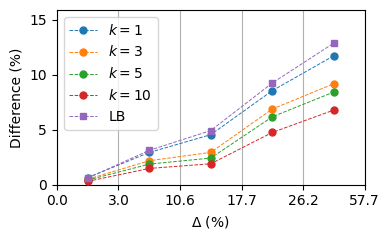

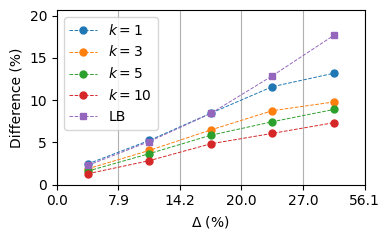

In [8]:
def show_diff_best_delta(results, model_name="PR-KNN", savedir=None):
    baselines = ["LB"]
    for algo, res in results.items():
        
        plt.figure(figsize=(4, 2.5))        
        best_scores = np.concatenate(res["Best"]["scores"])
        y = {}
        Y = np.concatenate([train_res[algo]["Y"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
        l = [(max(y[y>0]) - np.quantile(y[y>0], 0.))/max(y[y>0]) for y in Y]
        x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 6)])
        
        x[0] -= 1e-4
        list_indices = [
            np.concatenate([
                [xr < (max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) - np.quantile(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0], 0.))/max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) <= x[r+1] for i in v["test_index"]] #
                for v in train_res[algo]["train_results"].values()
            ]) for r, xr in enumerate(x[:-1])
        ]

        for k in n_bests:
            y[k] = []
            scores = np.concatenate(res["proposed"][model_name]["scores"][k])
            for i, indices in enumerate(list_indices):
                v = np.mean(((best_scores-scores)/best_scores)[indices])
                y[k].append(v*100)

        for name in baselines:
            y[name] = []
            for i, indices in enumerate(list_indices):
                scores = np.concatenate(res[name]["scores"][k] if name in ["ARB"] else res[name]["scores"])
                v = np.mean(((best_scores-scores)/best_scores)[indices])
                y[name].append(v*100)

        n_bar = len(y)
        z = np.arange(len(x))
        i = 0
        max_ = np.zeros(len(list_indices))
        for k, values in y.items():
            max_ = np.maximum(max_, values)
            plt.plot(z[:-1]+0.5, values, "--o" if k not in baselines else "--s", linewidth=0.7, label=f"$k={k}$" if k not in baselines else k, markersize=5, alpha=1 if i<6 else 0.7, zorder=10)
            i += 1

        plt.xlim((z[0], z[-1]))
        plt.ylabel("Difference (%)")
        plt.xticks(z, [f"{max(0, val*100):.1f}" for val in x], fontsize=10)
        plt.ylim((0, max(max_)+3))
        plt.grid(axis="x")
        plt.legend(loc= "upper left")
        plt.xlabel("$\Delta$ (%)")

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"diff_best_delta_{algo}_{model_name}.pdf"))
        plt.show()

show_diff_best_delta(results, model_name="PR-KNN")

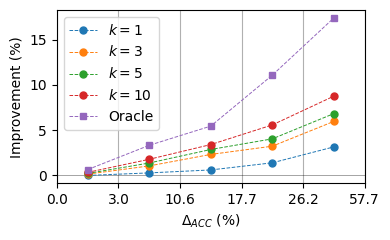

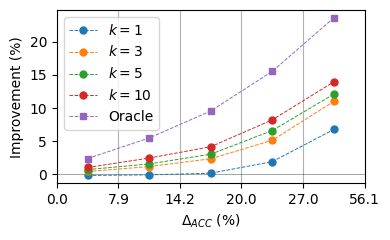

In [9]:
def show_diff_lb_delta(results, model_name="PR-KNN", savedir=None):
    baselines = ["Oracle"]
    for algo, res in results.items():
        
        plt.figure(figsize=(4, 2.5))        
        lb_scores = np.concatenate(res["LB"]["scores"])
        y = {}
        Y = np.concatenate([train_res[algo]["Y"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
        l = [(max(y[y>0]) - np.quantile(y[y>0], 0.))/max(y[y>0]) for y in Y]
        x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 6)])
        
        x[0] -= 1e-4
        list_indices = [
            np.concatenate([
                [xr < (max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) - np.quantile(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0], 0.))/max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) <= x[r+1] for i in v["test_index"]] #
                for v in train_res[algo]["train_results"].values()
            ]) for r, xr in enumerate(x[:-1])
        ]

        for k in n_bests:
            y[k] = []
            scores = np.concatenate(res["proposed"][model_name]["scores"][k])
            for i, indices in enumerate(list_indices):
                v = np.mean(((scores-lb_scores)/lb_scores)[indices])
                y[k].append(v*100)

        y["Oracle"] = []
        scores = np.concatenate(res["Best"]["scores"])
        for i, indices in enumerate(list_indices):
            v = np.mean(((scores-lb_scores)/lb_scores)[indices])
            y["Oracle"].append(v*100)


        n_bar = len(y)
        z = np.arange(len(x))
        i = 0
        max_ = np.zeros(len(list_indices))
        min_ = np.zeros(len(list_indices))
        for k, values in y.items():
            max_ = np.maximum(max_, values)
            min_ = np.minimum(min_, values)
            plt.plot(z[:-1]+0.5, values, "--o" if k not in baselines else "--s", linewidth=0.7, label=f"$k={k}$" if k not in baselines else k, markersize=5, alpha=1 if i<6 else 0.7, zorder=10)
            i += 1

        plt.xlim((z[0], z[-1]))
        plt.ylabel("Improvement (%)")
        plt.xticks(z, [f"{max(0, val*100):.1f}" for val in x], fontsize=10)
        plt.grid(axis="x")
        plt.legend(loc= "upper left")
        plt.axhline(color="black", alpha=0.5, linewidth=0.5)
        plt.xlabel("$\Delta_{ACC}$ (%)")

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"diff_lb_delta_{algo}_{model_name}.pdf"))
        plt.show()

show_diff_lb_delta(results, model_name="PR-KNN")

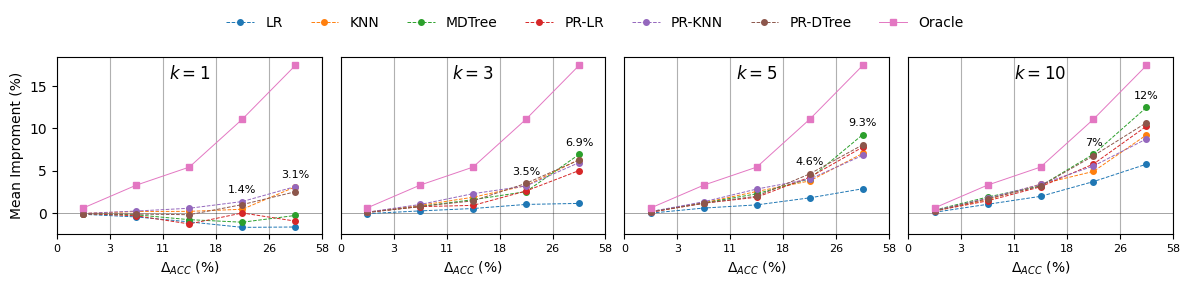

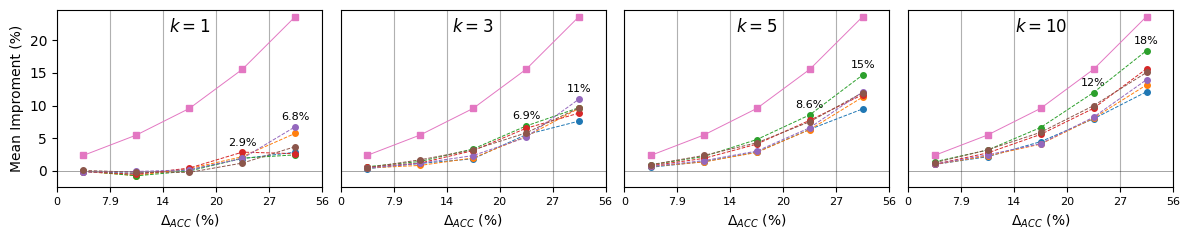

In [10]:
def show_diff_lb_delta(results, savedir=None):
    baselines = ["Oracle"]
    # model_names = ['LR', 'KNN', 'DTree', 'MKNN', 'MDTree', 'RankNetMSE', 'PR-LR', 'PR-KNN', 'PR-DTree']
    model_names = ["LR", "KNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"]
    for algo, res in results.items():
        plt.figure(figsize=(len(n_bests)*3, 2.5))
        for j, k in enumerate(n_bests):
            plt.subplot(1, len(n_bests), j+1)
            res = results[algo]
            
            lb_scores = np.concatenate(res["LB"]["scores"])
            y = {}
            Y = np.concatenate([train_res[algo]["Y"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
            l = [(max(y[y>0]) - np.quantile(y[y>0], 0.))/max(y[y>0]) for y in Y]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 6)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                np.concatenate([
                    [xr < (max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) - np.quantile(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0], 0.))/max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) <= x[r+1] for i in v["test_index"]] #
                    for v in train_res[algo]["train_results"].values()
                ]) for r, xr in enumerate(x[:-1])
            ]

            for model_name in model_names:
                y[model_name] = []
                scores = np.concatenate(res["proposed"][model_name]["scores"][k])
                for i, indices in enumerate(list_indices):
                    v = np.mean(((scores-lb_scores)/lb_scores)[indices])
                    y[model_name].append(v*100)

            for name in baselines:
                y[name] = []
                for i, indices in enumerate(list_indices):
                    scores = np.concatenate(res["Best"]["scores"])
                    v = np.mean(((scores-lb_scores)/lb_scores)[indices])
                    y[name].append(v*100)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            for model_name, values in y.items():
                if model_name != "Oracle":
                    max_ = np.maximum(max_, values)
                plt.plot(z[:-1]+0.5, values, "--o" if model_name not in baselines else "-s", linewidth=0.7, label=model_name if k==1 else None, markersize=4, alpha=1, zorder=10)
                i += 1

            for ind, val in enumerate(list_indices):
                if ind > 2:
                    plt.annotate(f"{max_[ind]:.2g}%", (z[ind]+0.5, max_[ind]+1), fontsize=8, ha="center")

            plt.xlim((z[0], z[-1]))
            
            plt.xticks(z, [f"{max(0, val*100):.2g}" for val in x], fontsize=8)
            plt.ylim((-2.5, max(y["Oracle"])+1))
            plt.grid(axis="x")
            plt.xlabel("$\Delta_{ACC}$ (%)")
            plt.axhline(color="black", linewidth=0.5, alpha=0.5)
            if k == 1: 
                plt.ylabel("Mean Improment (%)")
            if k > 1: 
                plt.yticks([])
                
            plt.title(f"$k={k}$", y=0.83)

        if algo=="HAverage": plt.figlegend(fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=7)
        plt.tight_layout(w_pad=0.5)
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"diff_lb_delta_{algo}.pdf"), bbox_inches='tight')
        plt.show()

show_diff_lb_delta(results)

207


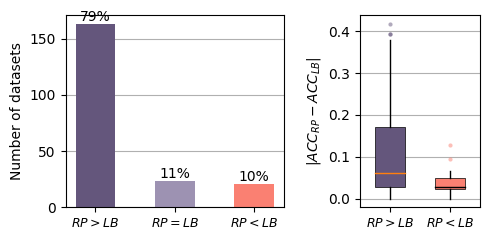

In [11]:
def show_diff_lb_per_method(results, algo="haverage", model_name="KNN", eps=0, k=1, savedir=None):
    res = results[algo]
    lb_scores = np.concatenate(res["LB"]["scores"])
    model_res = res["proposed"][model_name]
    Y = np.concatenate([train_res[algo]["Y"][v["test_index"]] for v in train_res[algo]["train_results"].values()])
    l = [(max(y[y>0]) - np.quantile(y[y>0], 0.))/max(y[y>0]) for y in Y]
    x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 6)])
    indices = np.concatenate([
            [1 >= (max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) - np.quantile(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0], 0.))/max(train_res[algo]["Y"][i][train_res[algo]["Y"][i]>0]) >= x[-2] for i in v["test_index"]] #train_res[algo]["ids"][i].split("_")[1]=="0" and  
            for v in train_res[algo]["train_results"].values()])
    print(sum(indices))
    plt.figure(figsize=(5, 2.5))
    y = []
    u = (np.concatenate(model_res["scores"][k]) - lb_scores)[indices]
    y.append(sum(u>0))
    y.append(sum(u==0))
    y.append(sum(u<0))
    y = np.array(y)

    labels = ["$RP>LB$", "$RP=LB$", "$RP<LB$"]
    colors = ["#64567C", "#9d92b2", "salmon"]
    w = 0.5
    plt.subplot(1, 5, (1,3))
    bar1 = plt.bar(labels, y, width=w, color=colors, zorder=2)
    sum_y = sum(y)
    plt.bar_label(bar1, [f"{round(v):2d}%" for v in y/sum_y*100], label_type="edge")
    plt.xticks(fontsize=9)
    plt.ylabel("Number of datasets")#, fontdict={'size': 12}
    # plt.ylim((0, 150))
    plt.grid(axis="y", zorder=0)

    plt.subplot(1, 5, (4,5))
    y1 = []
    y2 = []
    u = (np.concatenate(model_res["scores"][k]) - lb_scores)[indices]#/lb_scores*100
    y1.append(u[u>0])
    y2.append(-u[u<0])
    
    w = 0.5
    x = np.arange(2)
    boxprops1 = dict(linewidth=0.5, facecolor="#64567C") # 726686 
    boxprops2 = dict(linewidth=0.5, facecolor="salmon")
    flierprops1 = dict(marker='o', markerfacecolor='#64567C', markeredgecolor='none', markersize=3, alpha=0.5,
                    linewidth=0)
    flierprops2 = dict(marker='o', markerfacecolor='salmon', markeredgecolor='none', markersize=3, alpha=0.5,
                    linewidth=0)
    b1 = plt.boxplot(y1, positions=x[:1], widths=w,  patch_artist=True, boxprops=boxprops1, flierprops=flierprops1, showcaps=False)
    b2 = plt.boxplot(y2, positions=x[1:], widths=w,  patch_artist=True, boxprops=boxprops2, flierprops=flierprops2, showcaps=False, medianprops={"color":"black"})
    plt.xticks(x, [labels[0], labels[-1]], fontsize=9)
    plt.ylabel("$|ACC_{RP} - ACC_{LB}|$")
    plt.grid(axis="y", zorder=0)
    # plt.legend([b1["boxes"][0], b2["boxes"][0]], ["$RP>LB$", "$RP<LB$"], fontsize=8, framealpha=0.9, ncol=2, loc= "upper center", bbox_to_anchor= (0.5, 1)) #, title="Absolute difference when:" ------- $ACC_{RP}>ACC_{LB}

    plt.tight_layout(w_pad=1.5)
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"diff_lb_{algo}_{model_name}_{k}.pdf"))
    plt.show()

show_diff_lb_per_method(results, algo="KMedoids", k=5, model_name="MDTree")